# Law, Bias, and Algorithms
## Included variable bias (2/2)

1. [CODE] What is the right model for "risk" (i.e., what is the LHS?)
1. [DISCUSS] Explore and discuss risk distribution
1. [CODE] Given the risk estimate, how do you estimate disparate impact, adjusting for risk
1. [CODE] What are other legitimate variables---what does that even mean?!

In [1]:
# Some initial setup
options(digits = 3)
library(tidyverse)

theme_set(theme_bw())

# Read the data
stop_df <- read_rds("../data/sqf_sample.rds")

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 2.2.1     ✔ purrr   0.2.5
✔ tibble  1.4.2     ✔ dplyr   0.7.5
✔ tidyr   0.8.1     ✔ stringr 1.3.0
✔ readr   1.1.1     ✔ forcats 0.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


## Included variable bias

As we discussed last time, one common method for measuring disparities while addressing some of the omitted variable bias concerns is to include _all_ recorded data, that would have been available to the officer at the time of making the decision (to frisk an individual). This is also known as the "kitchen sink" approach.

In [2]:
race_coefficients <- c("suspect_raceblack", "suspect_racehispanic")

feats <- c(
    "suspected_crime",
    "precinct",
    "location_housing",
    "suspect_sex",
    "suspect_age",
    "suspect_height",
    "suspect_weight",
    "suspect_hair",
    "suspect_eye",
    "suspect_build",
    "additional_report",
    "additional_investigation",
    "additional_proximity",
    "additional_evasive",
    "additional_associating",
    "additional_direction",
    "additional_highcrime",
    "additional_time",
    "additional_sights",
    "additional_other",
    "stop_reason_object",
    "stop_reason_desc",
    "stop_reason_casing",
    "stop_reason_lookout",
    "stop_reason_clothing",
    "stop_reason_drugs",
    "stop_reason_furtive",
    "stop_reason_violent",
    "stop_reason_bulge",
    "stop_reason_other",
    "suspect_race"
)

# This creates a formula with a specified left-hand side (frisked), and using 
# all the variables in feats on the right-hand side. 
# Constructing a formula in this way (instead of typing out all the variable names)
# is helpful for constructing multiple models that share a long list of variables in the right-hand side.
kitchen_sink_formula <- as.formula(paste("frisked ~", paste(feats, collapse = "+")))

# We are only interested in the race coefficients
ks_model <- glm(kitchen_sink_formula, stop_df, family = binomial)
print(coef(ks_model)[race_coefficients])

   suspect_raceblack suspect_racehispanic 
               0.191                0.173 


The problems with including variables in measuring disparate impact is that the correlation between a feature and race itself is not necessarily justified.
An obvious example would be something like "skin color", where including skin color in the regression will likely account for observed disparities in race,
but the correlation between skin color and race is unlikely to be justified!
On the other hand, a less obvious example would be an officers suspicion of `cpw`.
While it seems reasonable that an officer would frisk individuals suspected of posessing a weapon more frequently,
the suspicion itself would only be justified if, and to the degree that, it is predictive of achieving the goal of a frisk: recovering weapons.

Blindly including a variable in the regression for treatment fails to take into account this _degree_ of justification, 
often overcompensating for variables that are correlated with race.
This is the problem known as _included variable bias_.

## Risk-adjusted regression

As we briefly discussed, controlling for any variable (i.e., including it in the regression) is only justified if, and to the degree that, the variable is _predictive of the outcome we are ultimately interested in_ (in this case, recovering a weapon). But the extent to which each variable is justified is rarely clear.

One simple idea for addressing this concern of included variable bias is to control for an explicit measure of **risk**, instead of controling for invididual variables.
Intuitively, we wish to know whether individuals who have _similar risk_ (of carrying a weapon) were treated (frisked) equally.

### Exercise 1: Estimating risk

In order to adjust for risk, we must first estimate it. This is relatively straight forward in the context of frisk decisions in stop-and-frisk, 
because the goal of a frisk is clear---we wish to recover weapons (`found_weapon`). 
In other words, we want to predict whether a weapon would be found if an individual is frisked. 
One simple way to achieve this is to build a model with `found_weapon` on the left-hand side, restricting the data to the individuals who were frisked.

* **Step 1**: Split train/test data
When dealing with predictive models, we always want to train our models on one subset of the data, while generating predictions and analyzing a different subset of the data.
This is to make sure that our analysis results are actually generalizable patterns, and not just something that happened to be true in the particular set of data that we collected.

While there are many ways to achieve this, one simple and managable way is to create a new column that indicates whether each row is (randomly) assigned to training or testing. 

- Use `mutate()` to create a new `fold` column in the `stop_df` data, which indicates whether each row is either `"train"` or "`test`"
- (Within the `mutate()` call) randomly assign either `"train"` or `"test"` to the `fold` column 
(Hint: you can use `sample()` to randomly shuffle a vector, and `rep_len()` to repeat the vector `c("train", "test")` up to a certain length)

In [4]:
# Add a fold column to stop_df, which is randomly assigned either "train" or "test"
# WRITE CODE HERE
# START solution
stop_df <- stop_df %>%
    mutate(fold = sample(rep_len(c("train", "test"), n())))
# END solution

* **Step 2**: `filter` the `stop_df` data to those individuals in the `"train"` _who were frisked_. We will call this new data frame `frisk_df`

In [5]:
# Subset the stop_df data to train cases where the individual was frisked
# WRITE CODE HERE
# START solution
frisk_df <- stop_df %>%
    filter(fold == "train", frisked)
# END solution

* **Step 3**: Fit a logistic regression where the left-hand side is whether or not a weapon was found (`found_weapon`) and the right-hand side is all reasonable variables (as listed in `feats` above). Let's call this model `risk_model`. Note that we use logistic regression here for simplicity, but in reality, more complex methods for predictive modeling would be employed, with additional measures to avoid overfitting.

In [6]:
# Using the subset of data from Step 2, fit the logistic regression model: found_weapon ~ (all legitimate features in feats) 
# WRITE CODE HERE
# START solution
risk_formula <- as.formula(paste("found_weapon ~", paste(feats, collapse = "+")))
risk_model <- glm(risk_formula, data = frisk_df, family = binomial)
# END solution

* **Step 4**: Use the `risk_model` from above to generate a column of model estimated risk (we'll name this column `risk`) on the original `stop_df` data. 

_Tip_: Given a `glm` model named `risk_model`, a vector of predictions for `stop_df` can be created with the command `predict(risk_model, stop_df)`.

In [7]:
# Generate a column of predicted risk 
# WRITE CODE HERE
# START solution
stop_df <- stop_df %>%
    mutate(risk = predict(risk_model, .))
# END solution

* **Step 5**: Recall that we (conceptually) split `stop_df` in two folds, with the goal of only using the `test` fold for analysis. 

Create a new data frame called `test_df`, which includes all the data from `stop_df` (including `risk`) which were assigned to the `"test"` fold.

In [8]:
test_df <- stop_df %>%
    filter(fold == "test")

Once we have a good measure of risk, we can easily compute the disparity on race, accounting for risk, by fitting a regression with the two variables: race and risk.

But before moving forward, we want to do at least a couple of checks to make sure that the risk model our analysis will rely on is reasonable, with certain desirable properties.

**Note**: The following sections require and assume the `test_df` data frame, which is the output of the previous exercise. So make sure you've completed it before proceeding.

### Calibration

Recall that our main goal in predicting risk is to use it as a basis of comparing "similarly risky individuals". 
So we would like for our risk score to assign similar scores to individuals of similar risk, across multiple groups.
For example, we want to make sure that a score of 0.5 means the same thing for male and female, and different race groups.
One way to check that this is true is to plot calibration, where we bin individuals by the predicted score,
and then plot the average predicted risk score in each bin on the x-axis, and the actual observed proportion of 
weapons found on the y-axis, while plotting points/lines separately for each group of interest.

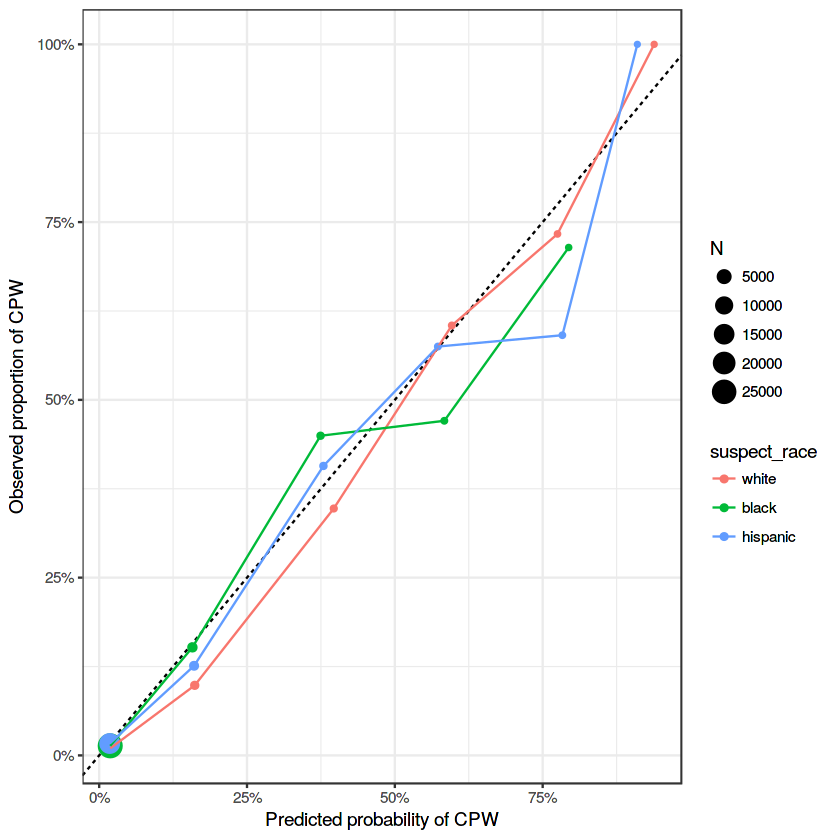

In [19]:
# TODO(?): We're being super hand-wavy here about scales (i.e., logit/probability). How much do we want/need to dive into the weeds?
# An example with race
race_calib_pd <- test_df %>%
    mutate(p_cpw = binomial()$linkinv(risk),
           risk_bin = plyr::round_any(p_cpw, 0.2)) %>%
    group_by(suspect_race, risk_bin) %>%
    summarize(N = n(),
              mean_cpw = mean(found_weapon),
              p_cpw = mean(p_cpw))

ggplot(race_calib_pd, aes(x = p_cpw, y = mean_cpw)) +
    geom_abline(intercept = 0, slope = 1, linetype = "dashed") +
    geom_point(aes(color = suspect_race, size = N)) +
    geom_line(aes(color = suspect_race)) +
    scale_x_continuous("Predicted probability of CPW", labels = scales::percent) +
    scale_y_continuous("Observed proportion of CPW", labels = scales::percent)

Finally, we are confident in our risk model, and ready to take the last step.

### Exercise 2: Risk-adjusted regression

Fit a logistic regression model to measure disparate impact on race, but only controling for risk, i.e., with the formula
`frisked ~ suspect_race + risk`

In [21]:
# WRITE CODE HERE
# START solution
glm(frisked ~ suspect_race + risk, stop_df, family = binomial)
# END solution


Call:  glm(formula = frisked ~ suspect_race + risk, family = binomial, 
    data = stop_df)

Coefficients:
         (Intercept)     suspect_raceblack  suspect_racehispanic  
               1.263                 0.807                 0.666  
                risk  
               0.228  

Degrees of Freedom: 99999 Total (i.e. Null);  99996 Residual
Null Deviance:	    120000 
Residual Deviance: 117000 	AIC: 117000